In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split,cross_validate

import pandas as pd 
print(tf.__version__)

2.8.0


In [ ]:
df = pd.read_excel('/content/Test_dataset.xlsx')
df.set_index('Date', inplace=True)
print(df)

# df.info()
# split_time = 420

Y_colname = ['MA5_f']
# X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
# X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_colname = ['Target', '1)철광석-중국', '4)철스크랩-터키수입가', '5)WTI', '5)BSI-해운지수', '2)중국-Flat재고', '3)중국-판재+롱재고', '4)중국-석탄내수', 
             '1)열연-미국', '1)열연-뭄바이', '1)열연-북유럽', '1)열연-한국', '1)GI-상해', '1)GI-미국']



            index  Target  shift_down  week    MA5  MA5_f     w_inc  w_inc_UD  \
Date                                                                            
2014-01-08      6   525.0       525.0     2  525.0  525.0  0.000000         1   
2014-01-09      7   525.0       525.0     3  525.0  525.0  0.000000         1   
2014-01-10      8   525.0       525.0     4  525.0  525.0  0.000000         1   
2014-01-13     11   525.0       525.0     0  525.0  525.0  0.000000         1   
2014-01-14     12   525.0       525.0     1  525.0  525.0  0.000000         1   
...           ...     ...         ...   ...    ...    ...       ...       ...   
2022-01-26   2483   765.0       762.0     2  760.0  775.6  1.385621         1   
2022-01-27   2484   770.0       765.0     3  762.8  777.0  0.909091         1   
2022-01-28   2485   777.0       770.0     4  766.6  777.6  0.077220         1   
2022-01-31   2488   777.0       777.0     0  770.2  780.2  0.411840         1   
2022-02-01   2489   777.0   

In [ ]:
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
Dataset = df[[x for x in df.columns if x in X_colname+Y_colname]]
Dataset = Dataset.dropna(axis=0)  # 데이터 없는거 지우기 (앞부분)
print(Dataset)

#칼럼 순서 바꾸기 - 예측 값을 끝으로 보냄
col1=Dataset.columns[0:1].to_list()
col2=Dataset.columns[1:2].to_list()
col3=Dataset.columns[2:].to_list()
new_col=col1+col3+col2
Dataset=Dataset[new_col]

print(Dataset)

#split_time = 437


            Target  MA5_f    1)철광석-중국      1)열연-미국  1)열연-뭄바이   1)열연-북유럽  \
Date                                                                      
2019-12-30   483.0  484.2   95.743000   625.010334    497.94   485.1555   
2019-12-31   483.0  485.2   95.944000   625.010334    496.57   486.7215   
2020-01-01   483.0  486.2   95.944000   628.317267    496.57   486.7215   
2020-01-02   485.0  487.2   96.803200   628.317267    496.57   488.6790   
2020-01-03   485.0  488.2   97.648000   628.317267    496.57   488.0148   
...            ...    ...         ...          ...       ...        ...   
2022-01-26   765.0  775.6  140.800506  1409.856167    874.87  1037.4840   
2022-01-27   770.0  777.0  140.473823  1409.856167    874.87  1026.7200   
2022-01-28   777.0  777.6  147.810362  1409.856167    874.87  1052.5410   
2022-01-31   777.0  780.2  147.024137  1409.856167    883.21  1054.2420   
2022-02-01   777.0  783.2  147.024137  1409.856167    883.21  1061.2550   

               1)열연-한국  

In [ ]:
# 추가 모델을 적용하고자 함

# 정규화 함수 
def MinMaxScaler(data):
    denom = np.max(data,0)-np.min(data,0)
    nume = data-np.min(data,0)
    return nume/denom

# 정규화 되돌리기 함수 
def back_MinMax(data,value):
    diff = np.max(data,0)-np.min(data,0)
    back = value * diff + np.min(data,0)
    return back 

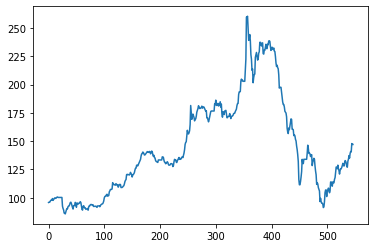

(547, 15)


In [ ]:
xy= np.array(Dataset)
#print(xy[:,1])

#%matplotlib notebook
plt.plot(xy[:,1]) # 전체 종가
plt.show()
print(xy.shape)


In [ ]:
seqLength = 20 # window size 
dataDim = 15 # 시가, 고가, 저가, 거래량 , 종가
hiddenDim = 10 
outputDim = 1
lr = 0.01
iterations = 300

#Dataset 구분 : Train 비율 80%, Test 비율 20%
trainSize = int(len(xy)*0.8)
trainSet = xy[0:trainSize]
testSet = xy[trainSize-seqLength:]

trainSet = MinMaxScaler(trainSet)
testSet = MinMaxScaler(testSet)


# 20일간의 15가지 데이터(00, 00, 00, ,, ,,)를 받아와서 
# 다음주 평균가격을 예측하는 모델로 구성

def buildDataSet(timeSeries, seqLength):
    xdata = []
    ydata = [] 
    for i in range(0, len(timeSeries)-seqLength):
        tx = timeSeries[i:i+seqLength,:-1]
        ty = timeSeries[i+seqLength-1,[-1]]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)
    
trainX, trainY=buildDataSet(trainSet, seqLength)
testX, testY=buildDataSet(testSet, seqLength)

In [ ]:
# RNN 모델 구성 

# First, let's define a RNN Cell, as a layer subclass.
from tensorflow import keras
from tensorflow.keras import layers

#model = keras.Sequential()

#model.add(layers.SimpleRNN(units=32, return_sequences=True, 
#                           activation='relu',
#                           input_shape=[seqLength ,dataDim -1]))
#model.add(layers.SimpleRNN(16), activation='relu')
#model.add(layers.Dense(16), activation='relu')
#model.add(layers.Dense(1))


model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(10, activation="relu", input_shape=[seqLength ,dataDim -1]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                250       
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 학습과정 설정 
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# 모델 트레이닝 
hist = model.fit(trainX, trainY, epochs=300, batch_size=16)

Epoch 1/300
27/27 [==============================] - 2s 9ms/step - loss: 0.0290 - mae: 0.1255
Epoch 2/300
27/27 [==============================] - 0s 7ms/step - loss: 0.0043 - mae: 0.0452
Epoch 3/300
27/27 [==============================] - 0s 11ms/step - loss: 0.0033 - mae: 0.0391
Epoch 4/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0032 - mae: 0.0377
Epoch 5/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0026 - mae: 0.0343
Epoch 6/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0028 - mae: 0.0363
Epoch 7/300
27/27 [==============================] - 0s 10ms/step - loss: 0.0021 - mae: 0.0324
Epoch 8/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0020 - mae: 0.0316
Epoch 9/300
27/27 [==============================] - 0s 12ms/step - loss: 0.0020 - mae: 0.0321
Epoch 10/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0035 - mae: 0.0424
Epoch 11/300
27/27 [==============================] - 0s

In [ ]:
# 모델 테스트 
res = model.evaluate(testX, testY, batch_size=16)
print("loss",res[0],"mae",res[1])


7/7 [==============================] - 0s 3ms/step - loss: 0.0829 - mae: 0.2734
loss 0.08287376910448074 mae 0.273428350687027


Evaluate : 0.08287377019876103
(110, 1)
(110, 1)


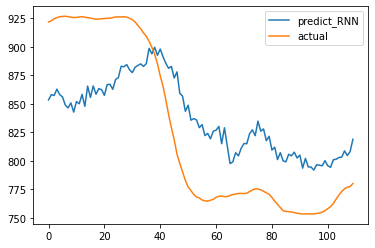

In [ ]:
import matplotlib.pyplot as plt 


#7 모델 사용
xhat = testX
yhat = model.predict(xhat)
#print(testY)
#print(yhat)

print("Evaluate : {}".format(np.average((yhat - testY)**2)))

# 원래 값으로 되돌리기 
predict1 = back_MinMax(xy[trainSize-seqLength:,[-1]],yhat)
actual = back_MinMax(xy[trainSize-seqLength:,[-1]],testY)
#print("예측값",predict1)
#print("실제값",actual)

#print("Evaluate : {}".format(np.average((predict - actual)**2)))

print(predict1.shape)
print(actual.shape)

 
#%matplotlib notebook
#plt.figure()
plt.plot(predict1, label = "predict_RNN")
plt.plot(actual,label = "actual")
plt.legend()
plt.show()


In [ ]:
MAE = abs(actual - predict1).mean()
MSE = ((actual - predict1)**2).mean()
MAPE = (abs(actual - predict1)/actual*100).mean()

pd.options.display.float_format = '{:,.2f}'.format
display(pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T)

,MAE,MSE,MAPE
Score,49.38,"2,703.04",5.98


In [ ]:
# LSTM 모델링 
model2 = keras.Sequential()

model2.add(layers.LSTM(units=32, return_sequences=True, 
                           activation='relu',
                           input_shape=[seqLength ,dataDim -1]))

model2.add(layers.LSTM(16))
model2.add(layers.Dense(8))
model2.add(layers.Dense(1))

#model2 = tf.keras.models.Sequential([
#  tf.keras.layers.LSTM(64, return_sequences=True, activation="relu", input_shape=[seqLength ,dataDim -1]),
#  tf.keras.layers.LSTM(64, return_sequences=True),
#  tf.keras.layers.Dense(30, activation="relu"),
#  tf.keras.layers.Dense(10, activation="relu"),
#  tf.keras.layers.Dense(1)
#  #tf.keras.layers.Lambda(lambda x: x * 400)
#])

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 20, 32)            6016      
                                                                 
 lstm_9 (LSTM)               (None, 16)                3136      
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9,297
Trainable params: 9,297
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 학습과정 설정 
model2.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [ ]:

# 모델 트레이닝 
hist = model2.fit(trainX, trainY, epochs=300, batch_size=16)

Epoch 1/300
27/27 [==============================] - 4s 18ms/step - loss: 0.1238 - mae: 0.2461
Epoch 2/300
27/27 [==============================] - 0s 16ms/step - loss: 0.0062 - mae: 0.0604
Epoch 3/300
27/27 [==============================] - 0s 17ms/step - loss: 0.0028 - mae: 0.0394
Epoch 4/300
27/27 [==============================] - 0s 17ms/step - loss: 0.0018 - mae: 0.0320
Epoch 5/300
27/27 [==============================] - 0s 16ms/step - loss: 0.0013 - mae: 0.0277
Epoch 6/300
27/27 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0267
Epoch 7/300
27/27 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0251
Epoch 8/300
27/27 [==============================] - 0s 17ms/step - loss: 9.2492e-04 - mae: 0.0230
Epoch 9/300
27/27 [==============================] - 0s 17ms/step - loss: 8.6322e-04 - mae: 0.0225
Epoch 10/300
27/27 [==============================] - 0s 18ms/step - loss: 8.6321e-04 - mae: 0.0227
Epoch 11/300
27/27 [=================

In [ ]:
# 모델 테스트 
res2 = model2.evaluate(testX, testY, batch_size=16)
print("loss",res2[0],"mae",res2[1])

7/7 [==============================] - 1s 5ms/step - loss: 0.0826 - mae: 0.2455
loss 0.08260679990053177 mae 0.24546891450881958


In [ ]:
#7 모델 사용
xhat = testX
yhat = model2.predict(xhat)
#print(testY)
#print(yhat)

#print("Evaluate : {}".format(np.average((yhat - testY)**2)))

# 원래 값으로 되돌리기 
predict2 = back_MinMax(xy[trainSize-seqLength:,[-1]],yhat)
actual = back_MinMax(xy[trainSize-seqLength:,[-1]],testY)
#print("예측값",predict2)
#print("실제값",actual)

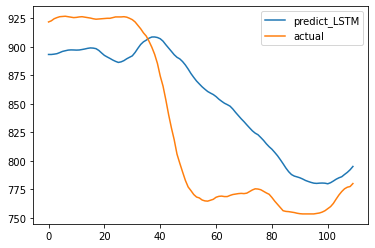

In [ ]:
#plt.figure()
plt.plot(predict2, label = "predict_LSTM")
plt.plot(actual,label = "actual")
plt.legend()
plt.show()

In [ ]:
MAE = abs(actual - predict2).mean()
MSE = ((actual - predict2)**2).mean()
MAPE = (abs(actual - predict2)/actual*100).mean()

pd.options.display.float_format = '{:,.2f}'.format
display(pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T)

,MAE,MSE,MAPE
Score,44.33,"2,694.33",5.51


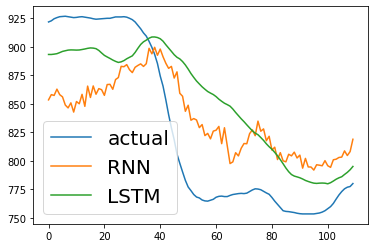

In [ ]:
plt.plot(actual,label = "actual")
plt.plot(predict1, label = "RNN")
plt.plot(predict2, label = "LSTM")


plt.legend(prop={'size': 20})